In [19]:
import pandas as pd
import numpy as np
import timeit

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20.0, 10.0)
from matplotlib import colors

import scipy.stats

In [20]:
import plot
import calculate

In [21]:
CAREER_LEN = 10

In [22]:
# Publication data
authorPublicationData = pd.read_csv('data/author_publications_2017_asiansAsNone.txt')
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count()

In [23]:
credible_authors = pd.read_csv('data/authors-scientific-atleast-'+ str(CAREER_LEN) + '-year_extended.csv', encoding='utf-8')

In [24]:
credible_authors = credible_authors.set_index('start_year')

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


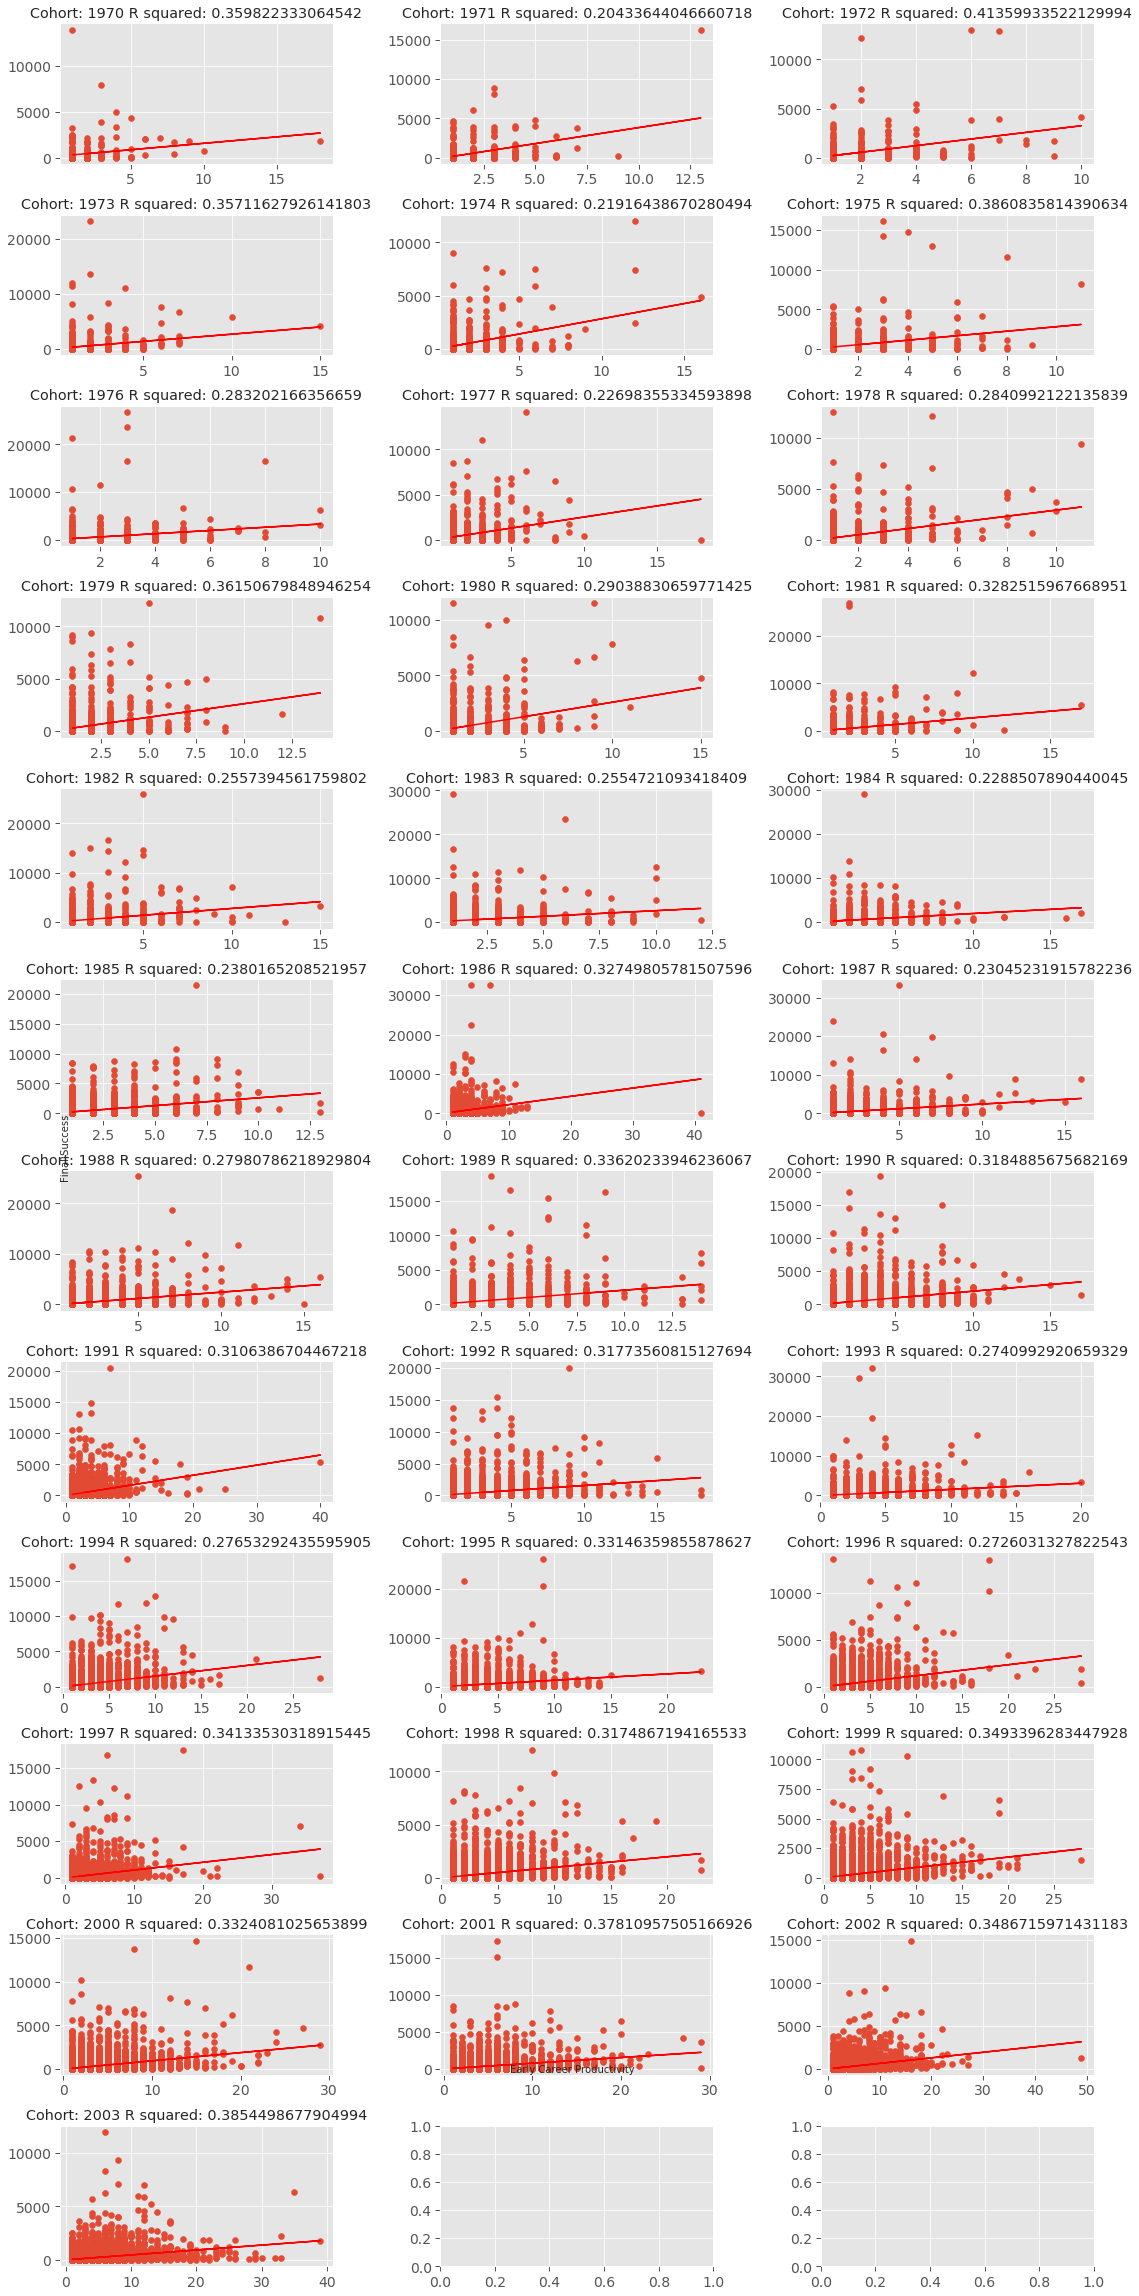

In [29]:
fig, ax = plt.subplots(nrows=12, ncols=3, sharex=False, sharey=False, figsize=(16,32))
for year in range(1970, 2004):
    data = credible_authors.loc[year]
    x = data['early_career_prod']
    y = data['final_citation_count']
    axes = ax[(year-1970)//3,year%1970%3]
    axes.scatter(x, y)
    fit = np.polyfit(x, y, deg=1)
    axes.plot(x, fit[0] * x + fit[1], color='red')
    axes.set_title("Cohort: " + str(year) + " R squared: " + str(r_value))
    # plt.xlim(0, 50)
    # plt.ylim(0,200)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    #     print(slope, intercept)
fig.text(0.5, 0.1, 'Early Career Productivity', ha='center', va='center')
fig.text(0.06, 0.5, 'Final Success', ha='center', va='center', rotation='vertical')
plt.show()

In [8]:
credible_authors.reset_index(inplace=True)

In [9]:
authorPublicationData = authorPublicationData.merge(credible_authors, how="inner", on=["author"])

In [10]:
authorPublicationData.shape
#inner

(7505827, 13)

In [11]:
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(authorPublicationData, 1, 'num_pub')

In [12]:
years = groupByYearData['year'].unique()
years = sorted(years)
END_YEAR = 2018
CAREER_LENGTH = 5
cohort_start_years = [y for y in years if y < (END_YEAR - CAREER_LENGTH)]

   year             author                                pub_id  start_year  \
0  1970       vijay wadhwa  8331129a-6b74-4cfc-8ac4-195691480640        1970   
1  1970      w. w. bledsoe  5aebf0d3-5eec-4768-aeb0-386e21c33fff        1970   
2  1970  gordon h. bradley  d05436b6-4cac-45b6-9385-b432d634879d        1970   

   end_year  num_pub  career_length  early_career_prod  early_career_prod_1  \
0      2007        2             38                  1                    1   
1      1991       22             22                 10                    2   
2      1998        7             29                  3                    2   

   early_career_prod_2  early_career_qual  final_citation_count gender  \
0                    1                  3                  58.0      m   
1                    8                556                 780.0   none   
2                    3                 47                  69.0      m   

   cum_num_pub  
0            2  
1           22  
2            7

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/danielkostic/cumulative-a

0
['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_', 'P', 'X']
('#DE4C2C', '#3BD64C', '#3B9ED6', '#B73BD6', '#F39C12', '#27AE60', '#AAB7B8', '#48C9B0', '#F4D03F')
<class 'str'>
<class 'str'>
1
['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_', 'P', 'X']
('#DE4C2C', '#3BD64C', '#3B9ED6', '#B73BD6', '#F39C12', '#27AE60', '#AAB7B8', '#48C9B0', '#F4D03F')
<class 'str'>
<class 'str'>
2
['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_', 'P', 'X']
('#DE4C2C', '#3BD64C', '#3B9ED6', '#B73BD6', '#F39C12', '#27AE60', '#AAB7B8', '#48C9B0', '#F4D03F')
<class 'str'>
<class 'str'>
3
['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_', 'P', 'X']
('#DE4C2C', '#3BD64C', '#3B9ED6', '#B73BD6', '#F39C12', '#27AE60', '#AAB7B8', '#48C9B0', '#F4D03F')
<cla

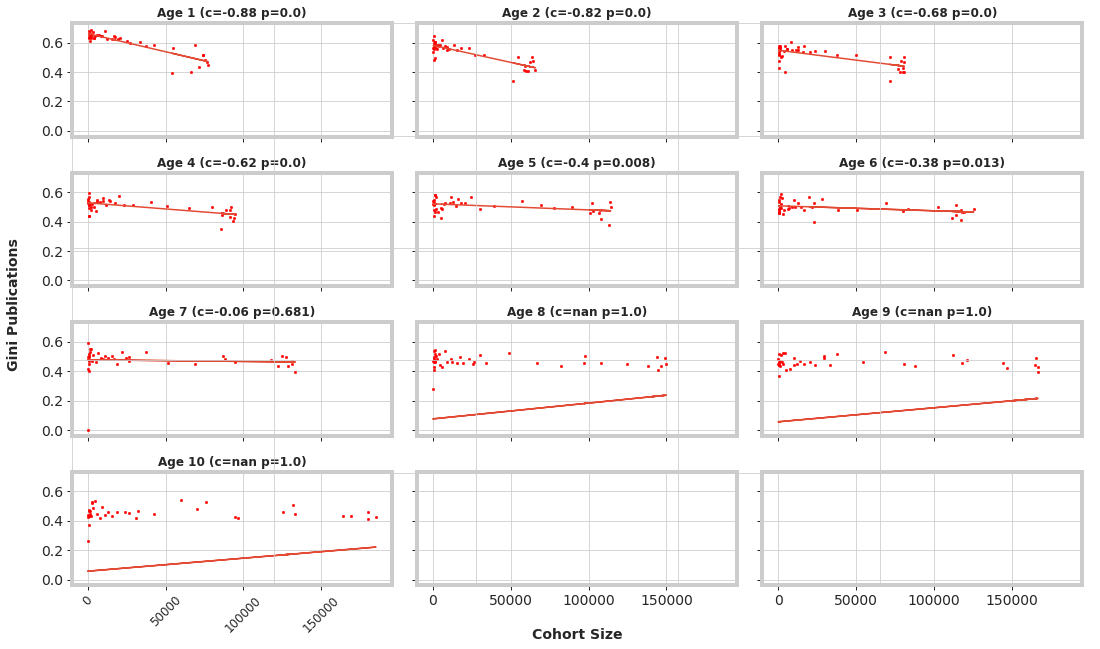

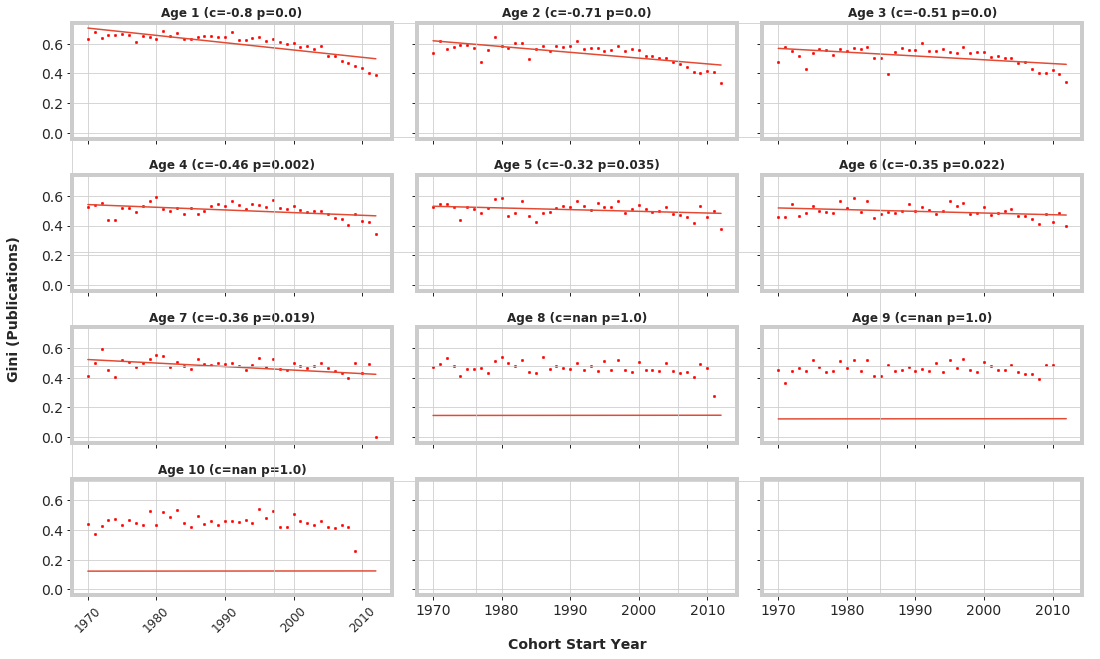

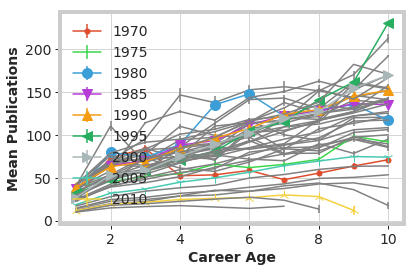

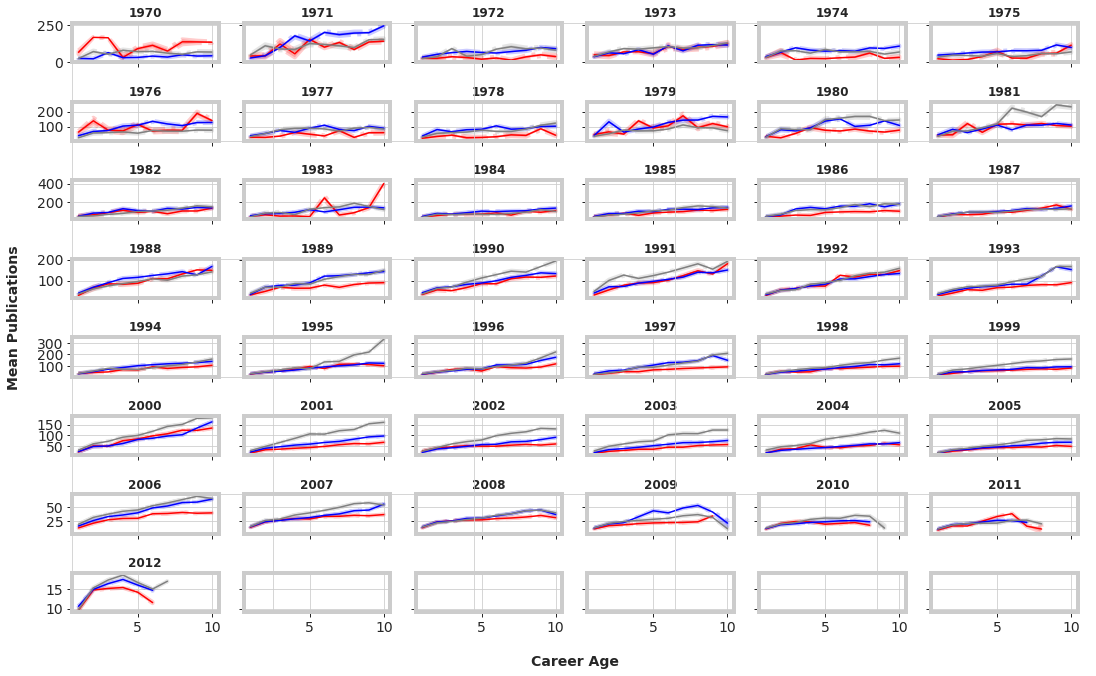

In [13]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, CAREER_LENGTH, "num_pub", "Publications")  